In [19]:
import cv2
import numpy as np
import pandas as pd
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score

In [9]:
cv2.__version__
import sklearn
sklearn.__version__

'0.23.1'

Let us first read the train and test files

In [93]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

In [94]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [95]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [206]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

In [182]:
print(len(Train_descriptors[0][1][1]))
Train_descriptors[0][1][3]

128


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,
         3.,   5.,  25.,   3.,   0.,   0.,   0.,  39.,   6.,   3.,   5.,
         0.,   0.,   0.,  14.,   5.,   0.,   0.,   0.,   1.,   1.,   0.,
         6.,   0.,   0.,   0.,   0.,   3.,   6.,   4.,   1., 111.,  80.,
       161., 153.,   6.,   0.,   0.,  21., 161.,  43.,  23.,  17.,   0.,
         0.,   0., 161.,  26.,   0.,   0.,   0.,   2.,   4.,   0.,  28.,
         0.,   0.,   0.,   0.,   8.,  29.,  29.,   4., 161.,  98.,  83.,
        50.,   0.,   0.,  89., 161., 161.,  57.,   3.,   0.,   0.,   0.,
         5., 161.,  12.,   1.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,
         0.,   3.,   1.,   0.,   1.,   2.,   0.], dtype=float32)

We now compute a k-means clustering on the descriptor space

In [207]:
# k = 128
k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [208]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [209]:
knn = KNeighborsClassifier(n_neighbors=14,n_jobs=-1,metric='minkowski')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(n_jobs=-1, n_neighbors=14)

We end up computing the test descriptors and compute the accuracy of the model

In [210]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [211]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
scores = cross_val_score(knn, visual_words_test, test_labels, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 200))

72.98636926889715
[0.7345679  0.74074074 0.72670807 0.70807453 0.60248447]
Accuracy: 70.25 (+/- 10.24)


## My own code

In [144]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
# print(precision)
y_pred= knn.predict(visual_words_test)
precision=100*precision_score(y_pred, test_labels,average='macro')
recall=100*recall_score(y_pred, test_labels,average='macro')
print(precision,recall)

56.877323420074354
57.14529120333209 59.115441921219094


KNN function to loop

In [212]:
def run_different_knn(neigh,metric):
    knn = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
    knn.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
#         des=compute_dense_sift(gray,SIFTdetector)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
    accuracy = 100*knn.score(visual_words_test, test_labels)
    y_pred= knn.predict(visual_words_test)
    precision=100*precision_score(y_pred, test_labels,average='macro')
    recall=100*recall_score(y_pred, test_labels,average='macro')
    
    return precision,recall,accuracy

DENSE SIFT

In [202]:
# ima=cv2.imread(r'C:\Users\adama\OneDrive/Dokumenty/Master of Computer Vision/M3/Databases/MIT_split/train/forest/art114.jpg')
# gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

def compute_dense_sift(gray,sift):
    step_size = 20
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    dense_feat = sift.compute(gray, kp)
    dense_feat_des = dense_feat[1]
    return dense_feat_des

128
0.0


PCA

In [ ]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

In [65]:
def run_different_knn_PCA(neigh,metric):
    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
    knnpca.fit(VWpca, train_labels) 
#     knn = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
#     knn.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
#         des=compute_dense_sift(gray,SIFTdetector)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    y_pred = knnpca.predict(vwtestpca)
    
#     accuracy = 100*knn.score(visual_words_test, test_labels)
#     y_pred= knn.predict(visual_words_test)
    precision=100*precision_score(y_pred, test_labels,average='macro')
    recall=100*recall_score(y_pred, test_labels,average='macro')
    
    return precision,recall,accuracy

# Main analysis

In [283]:
data_confusion=[]
metric=['euclidean','manhattan','chebyshev','minkowski']
from datetime import datetime

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(dt_string)
for item in range(33,53,2):
    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing knn={item}")
    for m in metric:
        precision,recall,accuracy=run_different_knn(item,m)
        data_confusion.append([item,precision,recall, accuracy,m,'0','0','0'])
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} finished")
df=pd.DataFrame(data_confusion, columns=['knn','precision','recall','accuracy','metric','dense','pca','lda'])

13:58:09
13:58:09 started doing knn=33
13:59:42 started doing knn=35
14:01:23 started doing knn=37
14:03:02 started doing knn=39
14:04:48 started doing knn=41
14:06:41 started doing knn=43
14:08:34 started doing knn=45
14:12:49 started doing knn=47
14:16:01 started doing knn=49
14:20:17 started doing knn=51
14:24:17 finished


In [288]:
df.head()
with open('N300K128KNN1_51_ALL_DENSE.pkl','wb') as f:
     cPickle.dump(df_new,f)

In [261]:
with open('N300K128KNN33_51PCA0LDA0DENSE5.pkl','rb') as f:
    df_new=cPickle.load(f)
df_new.head()

,knn,precision,recall,accuracy,metric,dense,pca,lda
0,33,73.449175,73.888756,72.862454,euclidean,5,0,0
1,33,78.009843,77.850092,77.447336,manhattan,5,0,0
2,33,57.132082,59.091360,56.133829,chebyshev,5,0,0
3,33,73.449175,73.888756,72.862454,minkowski,5,0,0
4,35,73.171704,73.481822,72.614622,euclidean,5,0,0


In [262]:
df_all=df_all.append(df_new,ignore_index=True)

In [289]:
df_new=df

In [287]:
df_new.shape

(208, 8)

In [58]:
df_new=df_new.append(df_new_5,ignore_index=True)

    knn  precision     recall   accuracy     metric dense pca lda
0    33  73.449175  73.888756  72.862454  euclidean    20   0   0
1    33  78.009843  77.850092  77.447336  manhattan    20   0   0
2    33  57.132082  59.091360  56.133829  chebyshev    20   0   0
3    33  73.449175  73.888756  72.862454  minkowski    20   0   0
4    35  73.171704  73.481822  72.614622  euclidean    20   0   0
5    35  78.156664  77.940982  77.695167  manhattan    20   0   0
6    35  56.000694  58.214788  55.018587  chebyshev    20   0   0
7    35  73.171704  73.481822  72.614622  minkowski    20   0   0
8    37  72.182027  72.569882  71.623296  euclidean    20   0   0
9    37  78.551703  78.369286  78.066914  manhattan    20   0   0
10   37  55.565688  57.837488  54.646840  chebyshev    20   0   0
11   37  72.182027  72.569882  71.623296  minkowski    20   0   0
12   39  72.691533  73.008374  71.995043  euclidean    20   0   0
13   39  77.722887  77.445749  77.075589  manhattan    20   0   0
14   39  5

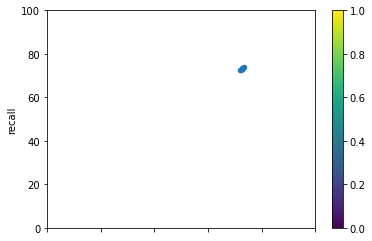

In [242]:
print(df)
# df['precision']=df['precision']/100
# df['recall']=df['recall']/100
df_eucl=df_new.metric=='euclidean'
df[df_eucl].plot.scatter(x='precision',y='recall',xlim=(0,100),ylim=(0,100),cmap='viridis')

max
    knn  precision     recall   accuracy     metric dense pca lda
9   37  78.551703  78.369286  78.066914  manhattan     0   0   0


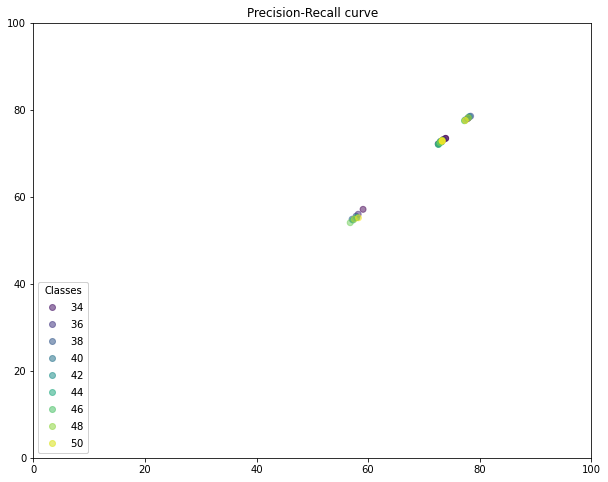

In [290]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Precision-Recall curve', xlim=(0,100), ylim=(0,100))

df2=df_new
# print(df2)
print("max\n",df2[df2.precision==df2.precision.max()])
# print(df2[df2.recall==df2.recall.max()])
scatter=ax.scatter(df2.recall, df2.precision, c=df2.knn,
           label=df2.knn,
           marker='o', alpha=.5,
           cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

PLOT by metric

max
      knn  precision     recall   accuracy     metric dense pca lda
117   27  78.640697  78.617144  78.314746  manhattan     5   0   0
     knn  precision     recall   accuracy     metric dense pca lda
117   27  78.640697  78.617144  78.314746  manhattan     5   0   0


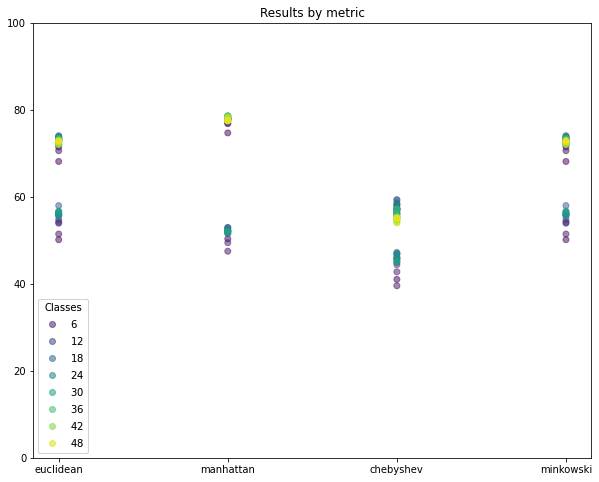

In [265]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Results by metric',ylim=(0,100))

df2=df_new
# print(df2)
print("max\n",df2[df2.precision==df2.precision.max()])
print(df2[df2.recall==df2.recall.max()])
scatter=ax.scatter(df2.metric, df2.precision, c=df2.knn,
           label=df2.knn,
           marker='o', alpha=.5,
           cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

max
      knn  precision     recall   accuracy     metric dense pca lda
117   27  78.640697  78.617144  78.314746  manhattan     5   0   0


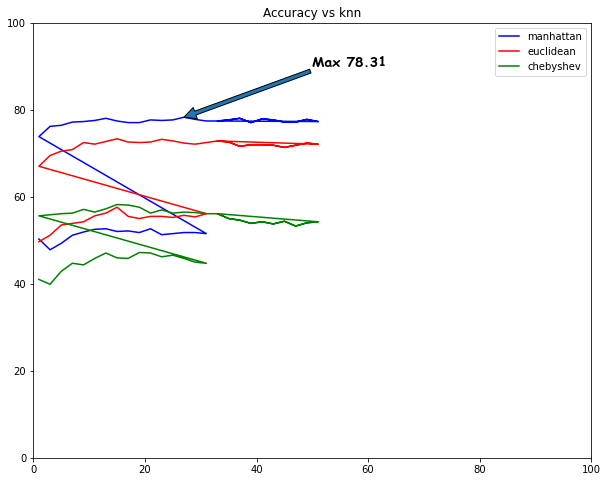

In [282]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs knn', xlim=(0,100), ylim=(0,100))

df2_man=df_new[(df_new.metric=='manhattan')]
df2_euc=df_new[df_new.metric=='euclidean']
df2_che=df_new[df_new.metric=='chebyshev']
# print(df2)
print("max\n",df2[df2.precision==df2.precision.max()])
# print(df2[df2.recall==df2.recall.max()])
ax.plot(df2_man.knn, df2_man.accuracy, color='b', label='manhattan')
ax.plot(df2_euc.knn, df2_euc.accuracy, color='r', label='euclidean')
ax.plot(df2_che.knn, df2_che.accuracy, color='g', label='chebyshev')
ax.legend()

# max_val = max(df_new.accuracy)
# max_idx = df_new.knn[df_new.accuracy.idxmax()]
# ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
#            weight='bold', size=14)

# arrowprops is a mpl.patches.FancyArrowPatch
_ = ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
                weight='bold', size=14, 
                xytext=(.5, .9),
                textcoords='axes fraction',
                family='comic sans ms',
                arrowprops={})

Dimensionality reduction, with PCA and LDA

In [60]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

55.14250309789344


In [88]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

59.727385377943


In [64]:
len(visual_words)

1881

In [65]:
len(train_labels)

1881